In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


# Veri setini yükleme ve işleme adımları
data = pd.read_csv(r"Data1/data.csv")

# Resim boyutları
height, width = 224, 224

# Resimleri yükleme ve işleme
X = np.empty((data.shape[0], height, width, 3))
for i in range(data.shape[0]):
    img = load_img(r"Data1/{}/{}.jpg".format(data.loc[i, 'label'], data.loc[i, 'images_id']),
                   target_size=(height, width))
    X[i] = img_to_array(img)

# Etiketleri değiştirme
def changeLabels(x):
    return labels[x]

labels = data.label.unique()
labels = {labels[i]: i for i in range(labels.size)}
y = data.label.apply(changeLabels)

# One-hot encoding
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, len(labels))

# Veri setini train-test olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [4]:
from tensorflow.keras.applications import MobileNetV3Large

# MobilNetV3 Large modelini yükleme
mobilenetv3 = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(height, width, 3))

# Transfer learning: MobilNetV3 Large modelinin üstüne yeni katmanlar ekleyerek özelleştirme
x = Flatten()(mobilenetv3.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.45)(x)
output = Dense(len(labels), activation='softmax')(x)

# Yeni modeli oluşturma
model_mobilenetv3 = Model(mobilenetv3.input, output)

# Modeli derleme
# Modeli derleme
model_mobilenetv3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 15
# Modelin eğitimi
stats_mobilenetv3 = model_mobilenetv3.fit(X_train, y_train, epochs=epochs, validation_split=0.2)


Epoch 1/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 31s 581ms/step - accuracy: 0.8417 - loss: 2.1018 - val_accuracy: 0.7150 - val_loss: 79.3899
Epoch 2/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 546ms/step - accuracy: 0.9948 - loss: 0.0382 - val_accuracy: 0.9372 - val_loss: 20.0098
Epoch 3/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 570ms/step - accuracy: 1.0000 - loss: 1.7259e-06 - val_accuracy: 0.9469 - val_loss: 15.9351
Epoch 4/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 545ms/step - accuracy: 0.9964 - loss: 0.0840 - val_accuracy: 0.8068 - val_loss: 21.8214
Epoch 5/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 544ms/step - accuracy: 0.9935 - loss: 0.3461 - val_accuracy: 0.9034 - val_loss: 19.7510
Epoch 6/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 558ms/step - accuracy: 0.9933 - loss: 0.1249 - val_accuracy: 0.9324 - val_loss: 52.3298
Epoch 7/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 543ms/step - accuracy: 1.0000 - loss: 2.0723e-04 - val_accuracy: 0.9420 - val_loss: 30.1204
Epoch 8/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 543ms/step - accuracy: 1.0000 - loss: 7.

Accuracy:
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.9943 - loss: 0.5261 
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step 


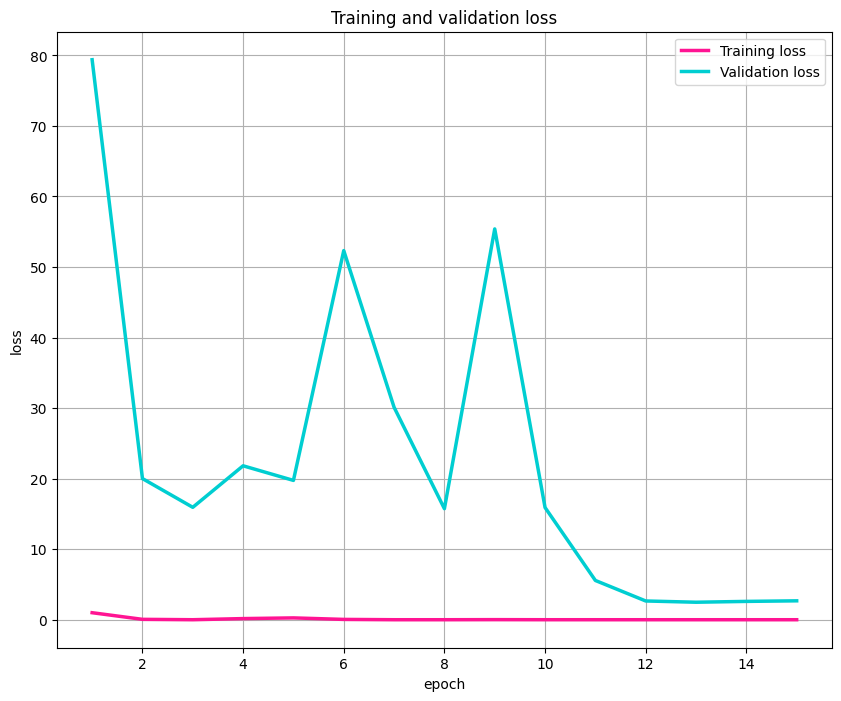

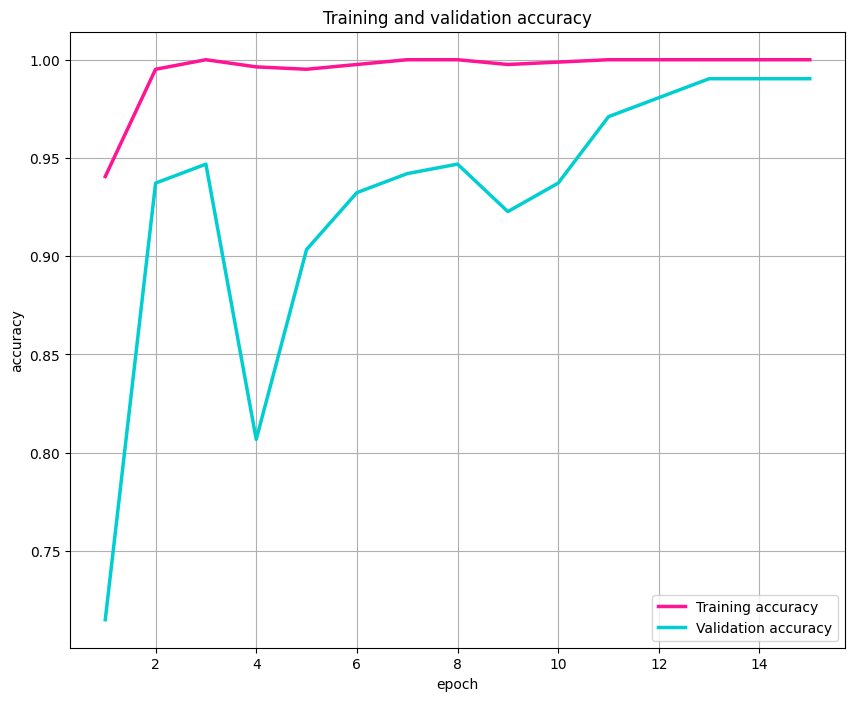

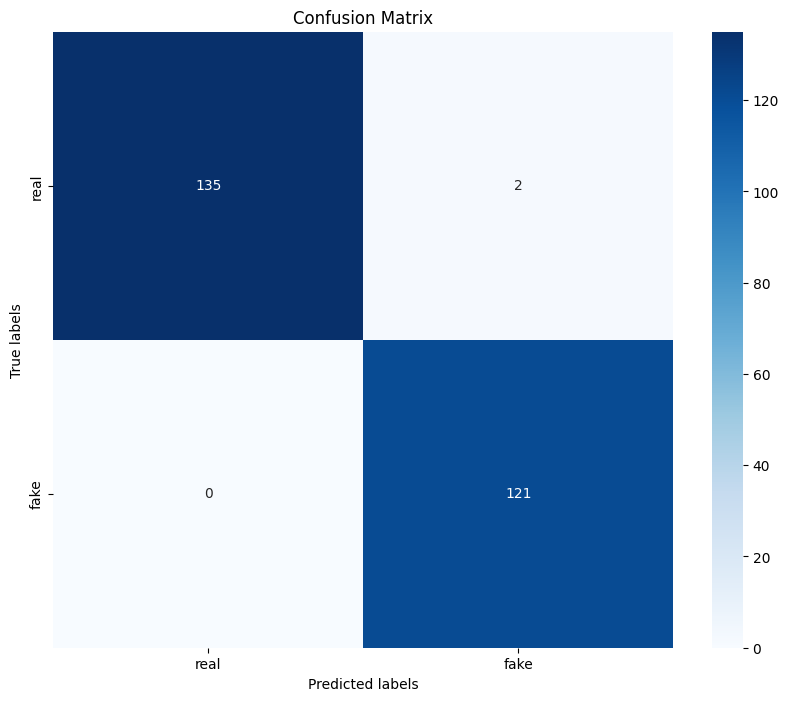

In [7]:
from sklearn.metrics import confusion_matrix

# Eğitim istatistiklerini görselleştirme
stats_mobilenetv3_df = pd.DataFrame(stats_mobilenetv3.history)
stats_mobilenetv3_df['epoch'] = list(range(1, epochs+1))

plt.figure(figsize=(10, 8))
sns.lineplot(y='loss', x='epoch', data=stats_mobilenetv3_df, color='deeppink', linewidth=2.5, label="Training loss")
sns.lineplot(y='val_loss', x='epoch', data=stats_mobilenetv3_df, color='darkturquoise', linewidth=2.5, label="Validation loss")
plt.grid()
plt.legend()
plt.title("Training and validation loss")

plt.figure(figsize=(10, 8))
sns.lineplot(y='accuracy', x='epoch', data=stats_mobilenetv3_df, color='deeppink', linewidth=2.5, label="Training accuracy")
sns.lineplot(y='val_accuracy', x='epoch', data=stats_mobilenetv3_df, color='darkturquoise', linewidth=2.5, label="Validation accuracy")
plt.grid()
plt.legend()
plt.title("Training and validation accuracy")

# Test verisi üzerinde modelin performansını değerlendirme
print('Accuracy:')
_, accuracy_mobilenetv3 = model_mobilenetv3.evaluate(X_test, y_test)

# Confusion Matrix
# Predictions
y_pred_mobilenetv3 = model_mobilenetv3.predict(X_test)
y_pred_classes_mobilenetv3 = np.argmax(y_pred_mobilenetv3, axis=1)

# Confusion matrix
# Test veri kümesinden doğru etiketleri y_true olarak tanımla
y_true = np.argmax(y_test, axis=1)

confusion_mtx_mobilenetv3 = confusion_matrix(y_true, y_pred_classes_mobilenetv3)

# Görselleştirme
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_mobilenetv3, annot=True, fmt='g', cmap='Blues', xticklabels=labels.keys(), yticklabels=labels.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()